<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/cabai_merah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [ ]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import math

from keras.utils.vis_utils import plot_model
from tensorflow.data import Dataset
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

## time step generator

In [ ]:
def time_step_generator(data, time_size, batch_size, shuffle_data):
  dataset = Dataset.from_tensor_slices(data)
  dataset = dataset.window(time_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(time_size+1))
  dataset = dataset.shuffle(shuffle_data)
  dataset = dataset.map(lambda x: (x[:-1], x[-1]))
  return dataset.batch(batch_size).prefetch(1)

def forecast_predict(model, data, time_size, batch_size):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

## Load data

In [ ]:
url ='https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_new.csv?raw=true'
urllib.request.urlretrieve(url, 'data_pangan.csv')

('data_pangan.csv', <http.client.HTTPMessage at 0x7f699c6896a0>)

In [ ]:
dataset = pd.read_csv('data_pangan.csv')
dataset.head()

,date,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam_ras_segar,daging_sapi_kualitas_1,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
0,2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,118400,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
1,2017-01-11,11400,10350,9900,11500,11300,12900,12350,30350,117000,...,30000,30000,30450,13900,12250,14950,14300,14500,16550,12900
2,2017-01-12,10700,9650,8500,11200,10950,12250,11850,29350,115800,...,33300,31500,35050,14000,12150,15400,14400,14800,16650,12950
3,2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,118400,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
4,2017-02-10,11400,10250,9850,11400,11250,12850,12350,30200,118400,...,31850,32550,31550,14000,12350,15000,14350,14700,16750,12950


In [ ]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [ ]:
dataset = dataset.set_index('date')
dataset = dataset.sort_index()
train = dataset.cabai_merah.values
date = dataset.index

## Train test val split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train, date, test_size=0.2, random_state=False, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=False, shuffle=False) # 0.125 x 0.48 = 0.1

print(f'{len(x_train)}\n{len(x_test)}')

818
234


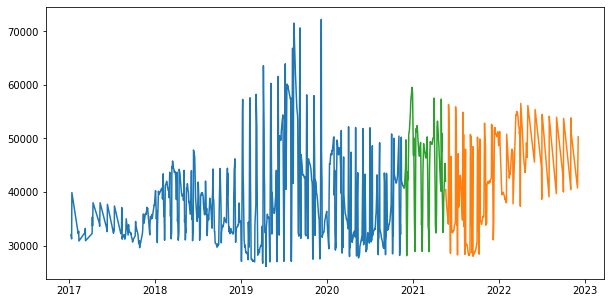

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_train, x_train)
plt.plot(y_test, x_test)
plt.plot(y_val, x_val)
plt.show()

## data generate

In [ ]:
scal_range= MinMaxScaler(feature_range=(0,1))
train_scal = scal_range.fit_transform(x_train.reshape(-1, 1))
test_scal = scal_range.fit_transform(x_test.reshape(-1, 1))
val_scal = scal_range.fit_transform(x_val.reshape(-1, 1))
train_step = time_step_generator(train_scal, time_size=600, shuffle_data=100, batch_size=5)
val_step = time_step_generator(val_scal, time_size=80, shuffle_data=100, batch_size=20)
test_step = time_step_generator(test_scal, time_size=150, shuffle_data=1000, batch_size=5)

train_step1 = time_step_generator(train_scal, time_size=100, shuffle_data=100, batch_size=1)
val_step1 = time_step_generator(val_scal, time_size=1, shuffle_data=10, batch_size=1)
test_step1 = time_step_generator(test_scal, time_size=10, shuffle_data=100, batch_size=1)

train_step2 = time_step_generator(train_scal, time_size=400, shuffle_data=1000, batch_size=5)
val_step2 = time_step_generator(val_scal, time_size=50, shuffle_data=100, batch_size=2)
test_step2 = time_step_generator(test_scal, time_size=100, shuffle_data=1000, batch_size=5)

In [ ]:
forecast = np.append(x_train, x_test)
forecast_date = np.append(y_train, y_test)
win_size= 400
win_size1 = 60
win_size2=150
test_cabaimerah_ = scal_range.fit_transform(forecast.reshape(-1, 1))

## model 

### SGD

In [ ]:
model= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
    LSTM(24, return_sequences=True),
    LSTM(20),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          48        
                                                                 
 lstm (LSTM)                 (None, None, 24)          3936      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3600      
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# plot_model(model, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

#### type1

In [ ]:
history = model.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 18s 64ms/step - loss: 0.0806 - mae: 0.2376 - mape: 92.4728 - val_loss: 0.2984 - val_mae: 0.4993 - val_mape: 91.6102
Epoch 2/30
44/44 [==============================] - 1s 21ms/step - loss: 0.0593 - mae: 0.1904 - mape: 65.1218 - val_loss: 0.2511 - val_mae: 0.4495 - val_mape: 79.2496
Epoch 3/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0452 - mae: 0.1589 - mape: 54.7714 - val_loss: 0.2183 - val_mae: 0.4113 - val_mape: 69.7685
Epoch 4/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0369 - mae: 0.1425 - mape: 55.2010 - val_loss: 0.1936 - val_mae: 0.3817 - val_mape: 63.1464
Epoch 5/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0317 - mae: 0.1349 - mape: 59.5221 - val_loss: 0.1763 - val_mae: 0.3610 - val_mape: 59.4040
Epoch 6/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0285 - mae: 0.1326 - mape: 65.1073 - val_loss: 0.1628 - val_mae: 0.3460 - val_mape: 57.39

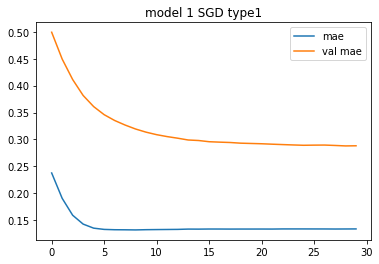

In [ ]:
mae = history.history['mae']
val_mae = history.history['val_mae']
epoch = range(len(mae))

plt.title('model 1 SGD type1')
plt.plot(epoch, mae, label='mae')
plt.plot(epoch, val_mae, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 7ms/step
7259.8115 16.90937 8805.94753561478


,date,actual,prediction
0,2021-05-20,40450,37967.929688
1,2021-05-21,39500,37935.316406
2,2021-05-24,37200,37980.085938
3,2021-05-25,36850,37955.484375
4,2021-05-27,35850,37989.707031
...,...,...,...
229,2022-11-02,40450,38655.953125
230,2022-11-03,53850,38722.714844
231,2022-11-04,51150,38675.902344
232,2022-12-01,40750,38717.710938


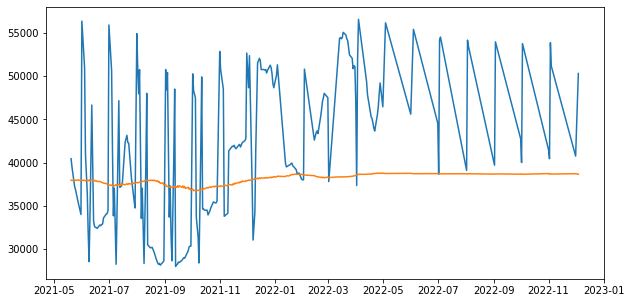

In [ ]:
prediction = forecast_predict(model, test_cabaimerah_, time_size=win_size, batch_size=5)

data_result = prediction[(len(x_train))-win_size:-1, -1 ]
data_result = scal_range.inverse_transform(data_result.reshape(-1, 1))
data_result = data_result.reshape(-1)
mae= tf.keras.metrics.mean_absolute_error(x_test, data_result)
mape = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result)
mse = tf.keras.metrics.mean_squared_error(x_test, data_result)

rmse =math.sqrt(mse.numpy())
print(mae.numpy(), mape.numpy(), rmse)

data_new_cabaimerah = pd.DataFrame()
data_new_cabaimerah['date'] = y_test
data_new_cabaimerah['actual'] = x_test
data_new_cabaimerah['prediction'] = data_result
data_new_cabaimerah.to_csv('cabaimerah_model1_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(data_new_cabaimerah.date, data_new_cabaimerah.actual)
plt.plot(data_new_cabaimerah.date, data_new_cabaimerah.prediction)
data_new_cabaimerah

#### type2

In [ ]:
history_t1 = model.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0317 - mae: 0.1380 - mape: 310354.1562 - val_loss: 0.0968 - val_mae: 0.2639 - val_mape: 50.0807
Epoch 2/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0310 - mae: 0.1380 - mape: 319039.5625 - val_loss: 0.0983 - val_mae: 0.2660 - val_mape: 50.3525
Epoch 3/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0310 - mae: 0.1373 - mape: 323220.5000 - val_loss: 0.0925 - val_mae: 0.2581 - val_mape: 49.9993
Epoch 4/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0307 - mae: 0.1363 - mape: 312774.5000 - val_loss: 0.0908 - val_mae: 0.2557 - val_mape: 49.9329
Epoch 5/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0304 - mae: 0.1352 - mape: 341801.6562 - val_loss: 0.0908 - val_mae: 0.2558 - val_mape: 49.9601
Epoch 6/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0302 - mae: 0.1352 - mape: 390527.8125 - val_loss: 0.0875 - val_

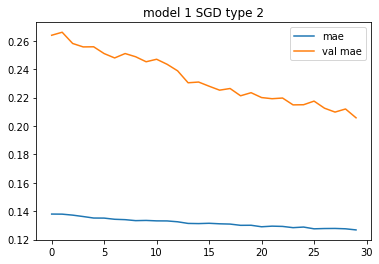

In [ ]:
mae_t1 = history_t1.history['mae']
val_mae_t1 = history_t1.history['val_mae']
epoch_t1 = range(len(mae_t1))

plt.title('model 1 SGD type 2')
plt.plot(epoch_t1, mae_t1, label='mae')
plt.plot(epoch_t1, val_mae_t1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
6230.1914 15.330293 7316.686135129756


,date,actual,prediction
0,2021-05-20,40450,37967.929688
1,2021-05-21,39500,37935.316406
2,2021-05-24,37200,37980.085938
3,2021-05-25,36850,37955.484375
4,2021-05-27,35850,37989.707031
...,...,...,...
229,2022-11-02,40450,38655.953125
230,2022-11-03,53850,38722.714844
231,2022-11-04,51150,38675.902344
232,2022-12-01,40750,38717.710938


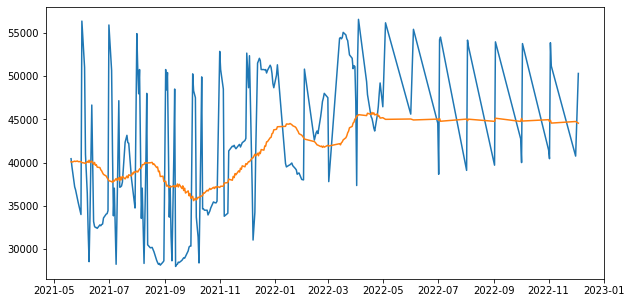

In [ ]:
win_size1 = 60
test_cabaimerah_1 = scal_range.fit_transform(forecast.reshape(-1, 1))
prediction_1 = forecast_predict(model, test_cabaimerah_1, time_size=win_size1, batch_size=5)

data_result_1 = prediction_1[(len(x_train))-win_size1:-1, -1 ]
data_result_1 = scal_range.inverse_transform(data_result_1.reshape(-1, 1))
data_result_1 = data_result_1.reshape(-1)
mae_1= tf.keras.metrics.mean_absolute_error(x_test, data_result_1)
mape_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_1)
mse_1 = tf.keras.metrics.mean_squared_error(x_test, data_result_1)
rmse_1 =math.sqrt(mse_1.numpy())
print(mae_1.numpy(), mape_1.numpy(), rmse_1)

data_new_cabaimerah_1 = pd.DataFrame()
data_new_cabaimerah_1['actual'] = x_test
data_new_cabaimerah_1['prediction'] = data_result_1
data_new_cabaimerah_1.to_csv('cabaimerah_model1_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_cabaimerah_1.actual)
plt.plot(y_test, data_new_cabaimerah_1.prediction)
data_new_cabaimerah

#### type3

In [ ]:
history_t2 = model.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0355 - mae: 0.1519 - mape: 550342.5625 - val_loss: 0.0569 - val_mae: 0.2052 - val_mape: 52.3726
Epoch 2/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0355 - mae: 0.1522 - mape: 559067.6875 - val_loss: 0.0565 - val_mae: 0.2047 - val_mape: 52.5103
Epoch 3/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0355 - mae: 0.1527 - mape: 566540.6250 - val_loss: 0.0560 - val_mae: 0.2039 - val_mape: 52.6975
Epoch 4/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0355 - mae: 0.1521 - mape: 567057.7500 - val_loss: 0.0561 - val_mae: 0.2041 - val_mape: 52.6074
Epoch 5/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0354 - mae: 0.1524 - mape: 566254.0625 - val_loss: 0.0556 - val_mae: 0.2034 - val_mape: 52.8235
Epoch 6/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0354 - mae: 0.1525 - mape: 569890.1875 - val_loss: 0.0556 - val_mae: 0

In [ ]:
mae_t2 = history_t2.history['mae']
val_mae_t2 = history_t2.history['val_mae']
epoch_t2 = range(len(mae_t2))

plt.title('cabaimerah kualitas rendah 1 model 1 SGD type 3')
plt.plot(epoch_t2, mae_t2, label='mae')
plt.plot(epoch_t2, val_mae_t2, label='val mae')
plt.legend()
plt.show()

In [ ]:
win_size2 = 150
prediction_2 = forecast_predict(model, test_cabaimerah_, time_size=win_size2, batch_size=5)

data_result_2 = prediction_2[(len(x_train))-win_size2:-1, -1 ]
data_result_2 = scal_range.inverse_transform(data_result_2.reshape(-1, 1))
data_result_2 = data_result_2.reshape(-1)
mae_2= tf.keras.metrics.mean_absolute_error(x_test, data_result_2)
mape_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_2)
mse_2 = tf.keras.metrics.mean_squared_error(x_test, data_result_2)

rmse_2 =math.sqrt(mse_2.numpy())
print(mae_2.numpy(), mape_2.numpy(), rmse_2)

data_new_cabaimerah_2 = pd.DataFrame()
# data_new_cabaimerah1['date'] = date_test
data_new_cabaimerah_2['actual'] = x_test
data_new_cabaimerah_2['prediction'] = data_result_2
data_new_cabaimerah_2.to_csv('cabaimerah_model1_sgd_type3')

plt.plot(y_test, data_new_cabaimerah_2.actual)
plt.plot(y_test, data_new_cabaimerah_2.prediction)
data_new_cabaimerah_2

### Adam

In [ ]:
model_a= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model_a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 16)          48        
                                                                 
 lstm_2 (LSTM)               (None, None, 24)          3936      
                                                                 
 lstm_3 (LSTM)               (None, 20)                3600      
                                                                 
 dense_2 (Dense)             (None, 64)                1344      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


#### Type 1

In [ ]:
history_a = model_a.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 4s 38ms/step - loss: 0.0701 - mae: 0.2151 - mape: 79.2625 - val_loss: 0.2297 - val_mae: 0.4240 - val_mape: 72.5520
Epoch 2/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0402 - mae: 0.1508 - mape: 55.1260 - val_loss: 0.1201 - val_mae: 0.2946 - val_mape: 52.4723
Epoch 3/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0227 - mae: 0.1269 - mape: 79.1159 - val_loss: 0.0663 - val_mae: 0.2183 - val_mape: 49.9802
Epoch 4/30
44/44 [==============================] - 1s 21ms/step - loss: 0.0217 - mae: 0.1303 - mape: 93.1507 - val_loss: 0.0663 - val_mae: 0.2182 - val_mape: 49.9895
Epoch 5/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0215 - mae: 0.1288 - mape: 89.5830 - val_loss: 0.0669 - val_mae: 0.2191 - val_mape: 49.9073
Epoch 6/30
44/44 [==============================] - 1s 21ms/step - loss: 0.0216 - mae: 0.1297 - mape: 90.4942 - val_loss: 0.0675 - val_mae: 0.2199 - val_mape: 49.851

In [ ]:
mae_a = history_a.history['mae']
val_mae_a = history_a.history['val_mae']
epoch_a = range(len(mae_a))

plt.title('cabaimerah kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a, mae_a, label='mae')
plt.plot(epoch_a, val_mae_a, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction_a = forecast_predict(model_a, test_cabaimerah_, time_size=win_size, batch_size=5)

data_result_a = prediction_a[(len(x_train))-win_size:-1, -1 ]
data_result_a = scal_range.inverse_transform(data_result_a.reshape(-1, 1))
data_result_a = data_result_a.reshape(-1)
mae_a= tf.keras.metrics.mean_absolute_error(x_test, data_result_a)
mape_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a)
mse_a = tf.keras.metrics.mean_squared_error(x_test, data_result_a)

rmse_a =math.sqrt(mse_a.numpy())
print(mae_a.numpy(), mape_a.numpy(), rmse_a)

data_new_cabaimerah_a = pd.DataFrame()
# data_new_cabaimerah1['date'] = date_test
data_new_cabaimerah_a['actual'] = x_test
data_new_cabaimerah_a['prediction'] = data_result_a
data_new_cabaimerah_a.to_csv('cabaimerah_model1_adam_type1.csv')

plt.figure(figsize=(10,5))
plt.plot(y_test, data_new_cabaimerah_a.actual)
plt.plot(y_test, data_new_cabaimerah_a.prediction)
data_new_cabaimerah_a

#### Type 2

In [ ]:
history_a1 = model_a.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0273 - mae: 0.1266 - mape: 368881.4375 - val_loss: 0.0608 - val_mae: 0.2115 - val_mape: 51.8377
Epoch 2/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0277 - mae: 0.1272 - mape: 300806.2188 - val_loss: 0.0627 - val_mae: 0.2139 - val_mape: 51.2745
Epoch 3/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0274 - mae: 0.1270 - mape: 310294.5000 - val_loss: 0.0548 - val_mae: 0.2031 - val_mape: 54.8585
Epoch 4/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0269 - mae: 0.1250 - mape: 261676.0781 - val_loss: 0.0549 - val_mae: 0.2032 - val_mape: 54.6806
Epoch 5/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0268 - mae: 0.1254 - mape: 368401.0312 - val_loss: 0.0588 - val_mae: 0.2090 - val_mape: 52.7726
Epoch 6/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0271 - mae: 0.1260 - mape: 329320.7500 - val_loss: 0.0579 - val_

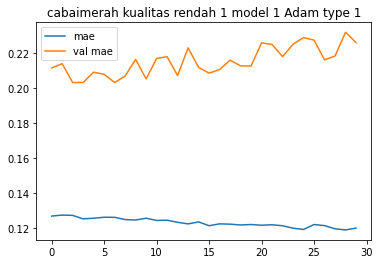

In [ ]:
mae_a1 = history_a1.history['mae']
val_mae_a1 = history_a1.history['val_mae']
epoch_a1 = range(len(mae_a1))

plt.title('cabaimerah kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a1, mae_a1, label='mae')
plt.plot(epoch_a1, val_mae_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
6437.456 16.422781 7506.992473687449


,actual,prediction
0,40450,43860.117188
1,39500,43607.007812
2,37200,43621.921875
3,36850,43274.371094
4,35850,43154.136719
...,...,...
229,40450,46486.554688
230,53850,45572.691406
231,51150,45818.648438
232,40750,45730.062500


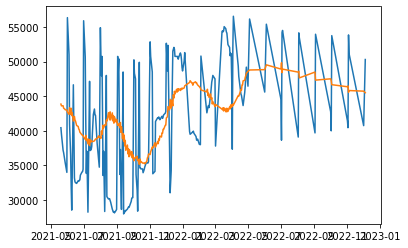

In [ ]:
prediction_a1 = forecast_predict(model_a, test_cabaimerah_, time_size=win_size1, batch_size=5)

data_result_a1 = prediction_a1[(len(x_train))-win_size1:-1, -1 ]
data_result_a1 = scal_range.inverse_transform(data_result_a1.reshape(-1, 1))
data_result_a1 = data_result_a1.reshape(-1)
mae_a1= tf.keras.metrics.mean_absolute_error(x_test, data_result_a1)
mape_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a1)
mse_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result_a1)

rmse_a1 =math.sqrt(mse_a1.numpy())
print(mae_a1.numpy(), mape_a1.numpy(), rmse_a1)

data_new_cabaimerah_a1 = pd.DataFrame()
data_new_cabaimerah_a1['actual'] = x_test
data_new_cabaimerah_a1['prediction'] = data_result_a1
data_new_cabaimerah_a1.to_csv('cabaimerah_model1_adam_type2.csv')

plt.plot(y_test, data_new_cabaimerah_a1.actual)
plt.plot(y_test, data_new_cabaimerah_a1.prediction)
data_new_cabaimerah_a1

#### Type 3

In [ ]:
history_a2 = model_a.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0320 - mae: 0.1417 - mape: 500266.4375 - val_loss: 0.0695 - val_mae: 0.2189 - val_mape: 48.3760
Epoch 2/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0315 - mae: 0.1419 - mape: 517005.8438 - val_loss: 0.0674 - val_mae: 0.2160 - val_mape: 48.6350
Epoch 3/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0315 - mae: 0.1413 - mape: 498913.9062 - val_loss: 0.0677 - val_mae: 0.2165 - val_mape: 48.5827
Epoch 4/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0315 - mae: 0.1417 - mape: 498496.2812 - val_loss: 0.0687 - val_mae: 0.2179 - val_mape: 48.4437
Epoch 5/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0315 - mae: 0.1419 - mape: 531533.4375 - val_loss: 0.0678 - val_mae: 0.2165 - val_mape: 48.5181
Epoch 6/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0313 - mae: 0.1408 - mape: 489524.7812 - val_loss: 0.0668 - val_mae: 0

In [ ]:
mae_a2 = history_a2.history['mae']
val_mae_a2 = history_a2.history['val_mae']
epoch_a2 = range(len(mae_a2))

plt.title('cabaimerah kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a2, mae_a2, label='mae')
plt.plot(epoch_a2, val_mae_a2, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction_a2 = forecast_predict(model_a, test_cabaimerah_, time_size=win_size2, batch_size=5)

data_result_a2 = prediction_a2[(len(x_train))-win_size2:-1, -1 ]
data_result_a2 = scal_range.inverse_transform(data_result_a2.reshape(-1, 1))
data_result_a2 = data_result_a2.reshape(-1)
mae_a2= tf.keras.metrics.mean_absolute_error(x_test, data_result_a2)
mape_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a2)
mse_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result_a2)

rmse_a2 =math.sqrt(mse_a2.numpy())
print(mae_a2.numpy(), mape_a2.numpy(), rmse_a2)

data_new_cabaimerah_a2 = pd.DataFrame()
# data_new_cabaimerah1['date'] = date_test
data_new_cabaimerah_a2['actual'] = x_test
data_new_cabaimerah_a2['prediction'] = data_result_a2
data_new_cabaimerah_a2.to_csv('cabaimerah_model1_adam_type3.csv')

plt.plot(y_test, data_new_cabaimerah_a2.actual)
plt.plot(y_test, data_new_cabaimerah_a2.prediction)
data_new_cabaimerah_a2

## model 1

### Adam

In [ ]:
model1= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae', 'mape'])
model1.summary()

#### Type 1

In [ ]:
history1 = model1.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 5s 41ms/step - loss: 0.0596 - mae: 0.1935 - mape: 73.0727 - val_loss: 0.1029 - val_mae: 0.2720 - val_mape: 50.4688
Epoch 2/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0242 - mae: 0.1368 - mape: 96.6579 - val_loss: 0.0744 - val_mae: 0.2296 - val_mape: 48.7227
Epoch 3/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0228 - mae: 0.1338 - mape: 91.8195 - val_loss: 0.0773 - val_mae: 0.2347 - val_mape: 48.9199
Epoch 4/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0230 - mae: 0.1344 - mape: 92.6608 - val_loss: 0.0681 - val_mae: 0.2197 - val_mape: 48.8659
Epoch 5/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0226 - mae: 0.1338 - mape: 92.4153 - val_loss: 0.0908 - val_mae: 0.2554 - val_mape: 49.6921
Epoch 6/15
44/44 [==============================] - 1s 23ms/step - loss: 0.0221 - mae: 0.1314 - mape: 90.4271 - val_loss: 0.0715 - val_mae: 0.2246 - val_mape: 48.633

In [ ]:
model1.evaluate(test_step)
mae1 = history1.history['mae']
val_mae1 = history1.history['val_mae']
epoch1 = range(len(mae1))

plt.figure(figsize=(10, 5))
plt.plot(epoch1, mae1, label='mae')
plt.plot(epoch1, val_mae1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction1 = forecast_predict(model1, test_cabaimerah_, time_size=win_size, batch_size=5)

data_result1 = prediction1[(len(x_train))-win_size:-1, -1 ]
data_result1 = scal_range.inverse_transform(data_result1.reshape(-1, 1))
data_result1 = data_result1.reshape(-1)
mae1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1)
mape1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1)
mse1 = tf.keras.metrics.mean_squared_error(x_test, data_result1)

rmse1 = math.sqrt(mse1.numpy())
print(mae1.numpy(), mape1.numpy(), rmse1)

data_new_cabaimerah1 = pd.DataFrame()
data_new_cabaimerah1['actual'] = x_test
data_new_cabaimerah1['prediction'] = data_result1
data_new_cabaimerah1.to_csv('cabaimerah_model2_adam_type1.csv')

data_new_cabaimerah1

In [ ]:
plt.figure(figsize=(40, 10))
plt.plot(range(len(x_test)), data_new_cabaimerah1['actual'], '-o')
plt.plot(range(len(x_test)), data_new_cabaimerah1['prediction'], '-o')

#### Type 2

In [ ]:
history1_1 = model1.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0290 - mae: 0.1329 - mape: 328812.3125 - val_loss: 0.0630 - val_mae: 0.2130 - val_mape: 50.0830
Epoch 2/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0280 - mae: 0.1288 - mape: 340523.5312 - val_loss: 0.0587 - val_mae: 0.2073 - val_mape: 51.5493
Epoch 3/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0268 - mae: 0.1275 - mape: 276769.5000 - val_loss: 0.0808 - val_mae: 0.2378 - val_mape: 48.7238
Epoch 4/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0263 - mae: 0.1265 - mape: 232621.7969 - val_loss: 0.0741 - val_mae: 0.2272 - val_mape: 48.7198
Epoch 5/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0268 - mae: 0.1263 - mape: 299071.0625 - val_loss: 0.0652 - val_mae: 0.2145 - val_mape: 49.5574
Epoch 6/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0262 - mae: 0.1236 - mape: 335243.1562 - val_loss: 0.0671 - val_

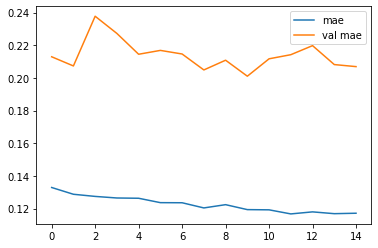

In [ ]:
mae1_1 = history1_1.history['mae']
val_mae1_1 = history1_1.history['val_mae']
epoch1_1 = range(len(mae1_1))

plt.plot(epoch1_1, mae1_1, label='mae')
plt.plot(epoch1_1, val_mae1_1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
6699.8687 16.709045 7876.909800169099


,actual,prediction
0,40450,44873.343750
1,39500,44029.925781
2,37200,44240.367188
3,36850,43636.996094
4,35850,43527.554688
...,...,...
229,40450,41677.621094
230,53850,41461.847656
231,51150,40949.042969
232,40750,41200.292969


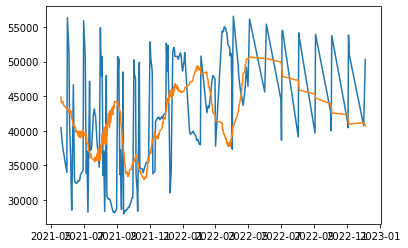

In [ ]:
prediction1_1 = forecast_predict(model1, test_cabaimerah_, time_size=win_size1, batch_size=5)

data_result1_1 = prediction1_1[(len(x_train))-win_size1:-1, -1 ]
data_result1_1 = scal_range.inverse_transform(data_result1_1.reshape(-1, 1))
data_result1_1 = data_result1_1.reshape(-1)
mae1_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_1)
mape1_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_1)
mse1_1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_1)

rmse1_1 = math.sqrt(mse1.numpy())
print(mae1_1.numpy(), mape1_1.numpy(), rmse1_1)

data_new_cabaimerah1_1 = pd.DataFrame()
data_new_cabaimerah1_1['actual'] = x_test
data_new_cabaimerah1_1['prediction'] = data_result1_1
data_new_cabaimerah1_1.to_csv('cabaimerah_model2_adam_type2.csv')

plt.plot(y_test, data_new_cabaimerah1_1.actual)
plt.plot(y_test, data_new_cabaimerah1_1.prediction)
data_new_cabaimerah1_1

#### Type 3

In [ ]:
history1_2 = model1.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 2s 18ms/step - loss: 0.0307 - mae: 0.1395 - mape: 365860.4688 - val_loss: 0.0657 - val_mae: 0.2115 - val_mape: 48.1574
Epoch 2/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0305 - mae: 0.1379 - mape: 349033.5312 - val_loss: 0.0726 - val_mae: 0.2198 - val_mape: 47.1697
Epoch 3/15
84/84 [==============================] - 1s 15ms/step - loss: 0.0303 - mae: 0.1368 - mape: 351632.2812 - val_loss: 0.0748 - val_mae: 0.2234 - val_mape: 47.1082
Epoch 4/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0301 - mae: 0.1351 - mape: 350176.1250 - val_loss: 0.0721 - val_mae: 0.2203 - val_mape: 47.2740
Epoch 5/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0302 - mae: 0.1354 - mape: 390820.2812 - val_loss: 0.0771 - val_mae: 0.2276 - val_mape: 46.9152
Epoch 6/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0300 - mae: 0.1352 - mape: 343535.0000 - val_loss: 0.0765 - val_mae: 0

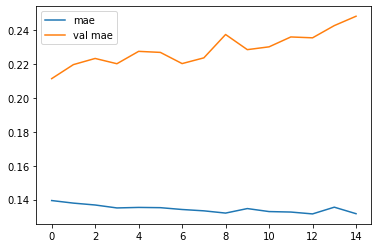

In [ ]:
mae1_2 = history1_2.history['mae']
val_mae1_2 = history1_2.history['val_mae']
epoch1_2 = range(len(mae1_2))

plt.plot(epoch1_2, mae1_2, label='mae')
plt.plot(epoch1_2, val_mae1_2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
6670.783 16.478806 7876.909800169099


,actual,prediction
0,40450,44607.632812
1,39500,43807.792969
2,37200,44214.003906
3,36850,43601.394531
4,35850,43671.480469
...,...,...
229,40450,43209.527344
230,53850,42730.058594
231,51150,42512.937500
232,40750,42370.843750


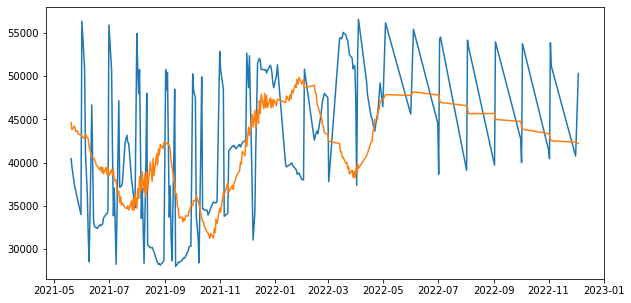

In [ ]:
prediction1_2 = forecast_predict(model1, test_cabaimerah_, time_size=win_size2, batch_size=5)

data_result1_2 = prediction1_2[(len(x_train))-win_size2:-1, -1 ]
data_result1_2 = scal_range.inverse_transform(data_result1_2.reshape(-1, 1))
data_result1_2 = data_result1_2.reshape(-1)
mae1_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_2)
mape1_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_2)
mse1_2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_2)
rmse1_2 = math.sqrt(mse1.numpy())
print(mae1_2.numpy(), mape1_2.numpy(), rmse1_2)

data_new_cabaimerah1_2 = pd.DataFrame()
data_new_cabaimerah1_2['actual'] = x_test
data_new_cabaimerah1_2['prediction'] = data_result1_2
data_new_cabaimerah1_2.to_csv('cabaimerah_model2_adam_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_cabaimerah1_2.actual)
plt.plot(y_test, data_new_cabaimerah1_2.prediction)

data_new_cabaimerah1_2

### SGD

In [ ]:
model1_a= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1_a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model1_a.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_6 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_7 (LSTM)               (None, 32)                20608     
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

In [ ]:
# plot_model(model1, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

#### Type1 

In [ ]:
history1_a = model1_a.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 5s 46ms/step - loss: 0.0784 - mae: 0.2349 - mape: 91.8933 - val_loss: 0.3003 - val_mae: 0.5009 - val_mape: 91.8338
Epoch 2/15
44/44 [==============================] - 1s 21ms/step - loss: 0.0618 - mae: 0.1968 - mape: 67.9724 - val_loss: 0.2629 - val_mae: 0.4620 - val_mape: 82.1937
Epoch 3/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0489 - mae: 0.1678 - mape: 57.5292 - val_loss: 0.2337 - val_mae: 0.4293 - val_mape: 74.0678
Epoch 4/15
44/44 [==============================] - 1s 21ms/step - loss: 0.0403 - mae: 0.1480 - mape: 53.5455 - val_loss: 0.2114 - val_mae: 0.4025 - val_mape: 67.4336
Epoch 5/15
44/44 [==============================] - 1s 21ms/step - loss: 0.0345 - mae: 0.1386 - mape: 56.5609 - val_loss: 0.1946 - val_mae: 0.3828 - val_mape: 63.3697
Epoch 6/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0306 - mae: 0.1352 - mape: 62.9861 - val_loss: 0.1802 - val_mae: 0.3658 - val_mape: 60.277

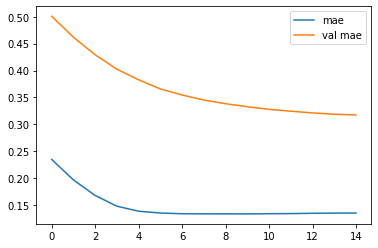

In [ ]:
mae1_a = history1_a.history['mae']
val_mae1_a = history1_a.history['val_mae']
epoch1_a = range(len(mae1_a))

plt.plot(epoch1_a, mae1_a, label='mae')
plt.plot(epoch1_a, val_mae1_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 7ms/step
7782.367 17.868576 9430.394689513265


,actual,prediction
0,40450,37025.636719
1,39500,37025.613281
2,37200,37028.148438
3,36850,37028.964844
4,35850,37030.941406
...,...,...
229,40450,37011.781250
230,53850,37021.324219
231,51150,37006.937500
232,40750,37022.464844


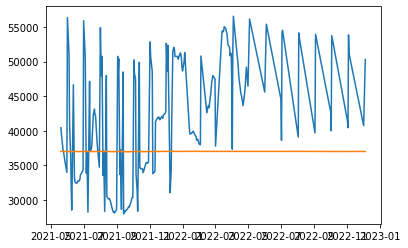

In [ ]:
prediction1_a = forecast_predict(model1_a, test_cabaimerah_, time_size=win_size, batch_size=5)

data_result1_a = prediction1_a[(len(x_train))-win_size:-1, -1 ]
data_result1_a = scal_range.inverse_transform(data_result1_a.reshape(-1, 1))
data_result1_a = data_result1_a.reshape(-1)
mae1_a = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a)
mape1_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a)
mse1_a = tf.keras.metrics.mean_squared_error(x_test, data_result1_a)

rmse1_a = math.sqrt(mse1_a.numpy())
print(mae1_a.numpy(), mape1_a.numpy(), rmse1_a)

data_new_cabaimerah1_a = pd.DataFrame()
data_new_cabaimerah1_a['actual'] = x_test
data_new_cabaimerah1_a['prediction'] = data_result1_a
data_new_cabaimerah1_a.to_csv('cabaimerah_model2_sgd_type1.csv')


plt.plot(y_test, data_new_cabaimerah1_a.actual)
plt.plot(y_test, data_new_cabaimerah1_a.prediction)

data_new_cabaimerah1_a

#### Type 2


In [48]:
history1_a1 = model1_a.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0339 - mae: 0.1430 - mape: 309998.8125 - val_loss: 0.1205 - val_mae: 0.2951 - val_mape: 52.1217
Epoch 2/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0337 - mae: 0.1432 - mape: 340999.6875 - val_loss: 0.1184 - val_mae: 0.2924 - val_mape: 51.8969
Epoch 3/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0338 - mae: 0.1435 - mape: 328138.1250 - val_loss: 0.1187 - val_mae: 0.2928 - val_mape: 51.9319
Epoch 4/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0337 - mae: 0.1437 - mape: 335528.9688 - val_loss: 0.1161 - val_mae: 0.2895 - val_mape: 51.6456
Epoch 5/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0337 - mae: 0.1431 - mape: 326929.2188 - val_loss: 0.1189 - val_mae: 0.2930 - val_mape: 51.9465
Epoch 6/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0336 - mae: 0.1433 - mape: 444496.6562 - val_loss: 0.1203 - val_

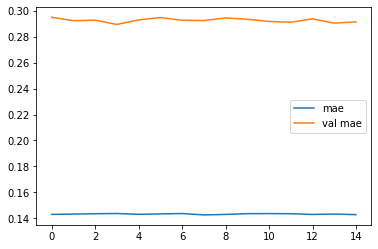

In [49]:
mae1_a1 = history1_a1.history['mae']
val_mae1_a1 = history1_a1.history['val_mae']
epoch1_a1 = range(len(mae1_a1))

plt.plot(epoch1_a1, mae1_a1, label='mae')
plt.plot(epoch1_a1, val_mae1_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
7407.8345 17.599733 8808.146229485521


,actual,prediction
0,40450,38555.773438
1,39500,38533.214844
2,37200,38554.343750
3,36850,38533.191406
4,35850,38552.605469
...,...,...
229,40450,38632.503906
230,53850,38616.316406
231,51150,38642.324219
232,40750,38619.746094


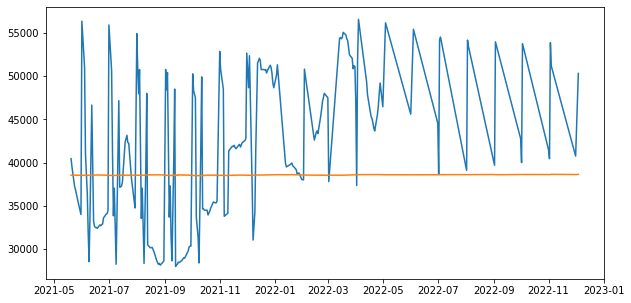

In [50]:
prediction1_a1 = forecast_predict(model1_a, test_cabaimerah_, time_size=win_size1, batch_size=5)

data_result1_a1 = prediction1_a1[(len(x_train))-win_size1:-1, -1 ]
data_result1_a1 = scal_range.inverse_transform(data_result1_a1.reshape(-1, 1))
data_result1_a1 = data_result1_a1.reshape(-1)
mae1_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a1)
mape1_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a1)
mse1_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a1)

rmse1_a1 = math.sqrt(mse1_a1.numpy())
print(mae1_a1.numpy(), mape1_a1.numpy(), rmse1_a1)

data_new_cabaimerah1_a1 = pd.DataFrame()
data_new_cabaimerah1_a1['actual'] = x_test
data_new_cabaimerah1_a1['prediction'] = data_result1_a1
data_new_cabaimerah1_a1.to_csv('cabaimerah_model2_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_cabaimerah1_a1.actual)
plt.plot(y_test, data_new_cabaimerah1_a1.prediction)
data_new_cabaimerah1_a1

#### Type 3

In [51]:
history1_a2 = model1_a.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 2s 18ms/step - loss: 0.0455 - mae: 0.1729 - mape: 661661.3125 - val_loss: 0.1111 - val_mae: 0.2828 - val_mape: 51.0792
Epoch 2/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0450 - mae: 0.1732 - mape: 684669.3125 - val_loss: 0.1060 - val_mae: 0.2762 - val_mape: 50.6627
Epoch 3/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0447 - mae: 0.1730 - mape: 697864.5625 - val_loss: 0.1039 - val_mae: 0.2735 - val_mape: 50.4927
Epoch 4/15
84/84 [==============================] - 1s 15ms/step - loss: 0.0446 - mae: 0.1733 - mape: 719552.2500 - val_loss: 0.1020 - val_mae: 0.2708 - val_mape: 50.3274
Epoch 5/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0446 - mae: 0.1733 - mape: 718461.8750 - val_loss: 0.1010 - val_mae: 0.2695 - val_mape: 50.2468
Epoch 6/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0446 - mae: 0.1735 - mape: 726559.0000 - val_loss: 0.1004 - val_mae: 0

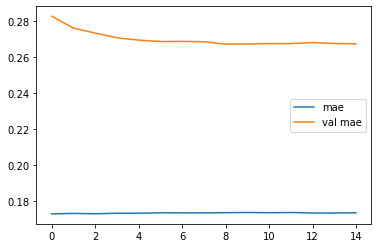

In [52]:
mae1_a2 = history1_a2.history['mae']
val_mae1_a2 = history1_a2.history['val_mae']
epoch1_a2 = range(len(mae1_a2))

plt.plot(epoch1_a2, mae1_a2, label='mae')
plt.plot(epoch1_a2, val_mae1_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
7190.046 17.810143 8393.072381434584


,actual,prediction
0,40450,40262.644531
1,39500,40240.199219
2,37200,40261.582031
3,36850,40240.976562
4,35850,40260.058594
...,...,...
229,40450,40356.445312
230,53850,40338.605469
231,51150,40367.269531
232,40750,40341.574219


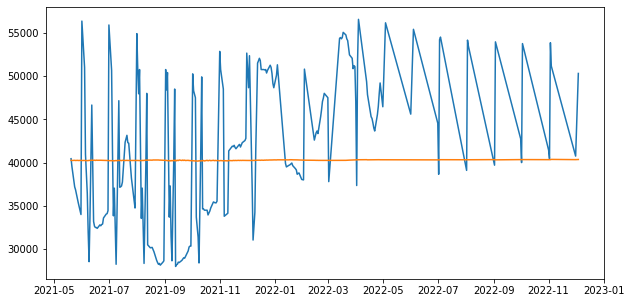

In [53]:
prediction1_a2 = forecast_predict(model1_a, test_cabaimerah_, time_size=win_size2, batch_size=5)

data_result1_a2 = prediction1_a2[(len(x_train))-win_size2:-1, -1 ]
data_result1_a2 = scal_range.inverse_transform(data_result1_a2.reshape(-1, 1))
data_result1_a2 = data_result1_a2.reshape(-1)
mae1_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a2)
mape1_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a2)
mse1_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a2)

rmse1_a2 = math.sqrt(mse1_a2.numpy())
print(mae1_a2.numpy(), mape1_a2.numpy(), rmse1_a2)

data_new_cabaimerah1_a2 = pd.DataFrame()
data_new_cabaimerah1_a2['actual'] = x_test
data_new_cabaimerah1_a2['prediction'] = data_result1_a2
data_new_cabaimerah1_a2.to_csv('cabaimerah_model2_sgd_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_cabaimerah1_a2.actual)
plt.plot(y_test, data_new_cabaimerah1_a2.prediction)

data_new_cabaimerah1_a2

## model 2

### SGD

In [54]:
model2= Sequential([
    Conv1D(8, kernel_size=5, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(14, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(24, activation='relu'),
    Dense(550, activation='relu'),
    Dense(1)
])

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, None, 8)           48        
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 8)          0         
 )                                                               
                                                                 
 lstm_8 (LSTM)               (None, None, 14)          1288      
                                                                 
 dropout (Dropout)           (None, None, 14)          0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                20224     
                                                                 
 dense_10 (Dense)            (None, 24)                1560      
                                                      

In [55]:
# plot_model(model2, to_file='model3_plot.png', show_shapes=True, show_layer_names=True)

#### Type 1

In [56]:
history2 = model2.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 5s 43ms/step - loss: 0.0807 - mae: 0.2390 - mape: 94.1748 - val_loss: 0.3085 - val_mae: 0.5090 - val_mape: 93.8584
Epoch 2/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0647 - mae: 0.2043 - mape: 72.6013 - val_loss: 0.2735 - val_mae: 0.4734 - val_mape: 85.0291
Epoch 3/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0530 - mae: 0.1762 - mape: 58.7327 - val_loss: 0.2461 - val_mae: 0.4435 - val_mape: 77.5982
Epoch 4/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0448 - mae: 0.1581 - mape: 54.5858 - val_loss: 0.2251 - val_mae: 0.4191 - val_mape: 71.5607
Epoch 5/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0390 - mae: 0.1461 - mape: 54.5208 - val_loss: 0.2081 - val_mae: 0.3984 - val_mape: 66.4217
Epoch 6/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0347 - mae: 0.1390 - mape: 57.0560 - val_loss: 0.1940 - val_mae: 0.3821 - val_mape: 63.242

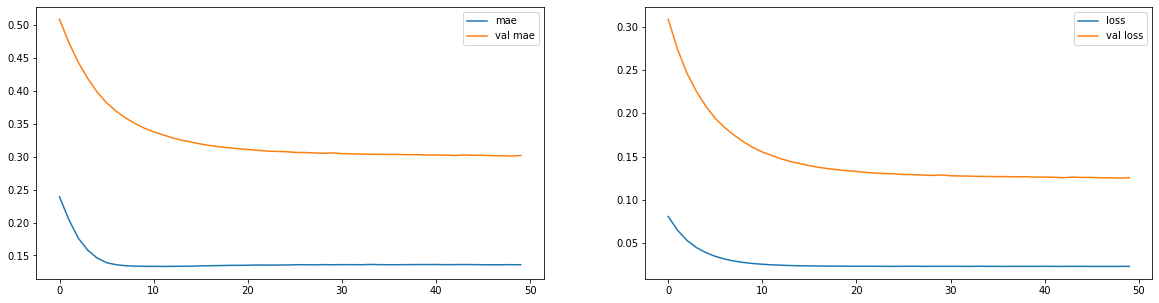

In [57]:
mae2 = history2.history['mae']
val_mae2 = history2.history['val_mae']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epoch2 = range(len(mae2))

plt.figure(figsize=(20, 5))
plt.subplot(1,2, 1)
plt.plot(epoch2, mae2, label='mae')
plt.plot(epoch2, val_mae2, label='val mae')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch2, loss2, label='loss')
plt.plot(epoch2, val_loss2, label='val loss')
plt.legend()
plt.show()

131/131 [==============================] - 1s 6ms/step
7527.71 17.499249 9080.615397647893


,actual,prediction
0,40450,37646.207031
1,39500,37623.953125
2,37200,37601.531250
3,36850,37618.148438
4,35850,37662.394531
...,...,...
229,40450,37940.300781
230,53850,37935.539062
231,51150,37920.878906
232,40750,37934.578125


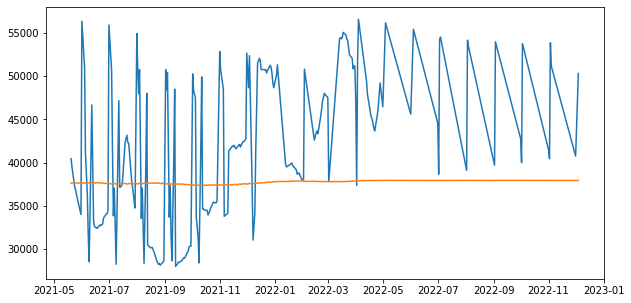

In [58]:
prediction2 = forecast_predict(model2, test_cabaimerah_, time_size=win_size, batch_size=5)

data_result2 = prediction2[(len(x_train))-win_size:-1, -1 ]
data_result2 = scal_range.inverse_transform(data_result2.reshape(-1, 1))
data_result2 = data_result2.reshape(-1)
mae2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2)
mape2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2)
mse2 = tf.keras.metrics.mean_squared_error(x_test, data_result2)

rmse2 = math.sqrt(mse2.numpy())
print(mae2.numpy(), mape2.numpy(), rmse2)

data_new_cabaimerah2 = pd.DataFrame()
data_new_cabaimerah2['actual'] = x_test
data_new_cabaimerah2['prediction'] = data_result2
data_new_cabaimerah2.to_csv('cabaimerah_medium_model3_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_cabaimerah2.actual)
plt.plot(y_test, data_new_cabaimerah2.prediction)
data_new_cabaimerah2

#### Type2

In [59]:
history2_1 = model2.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0335 - mae: 0.1426 - mape: 329282.0000 - val_loss: 0.1120 - val_mae: 0.2839 - val_mape: 51.1662
Epoch 2/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0331 - mae: 0.1424 - mape: 345826.4375 - val_loss: 0.1094 - val_mae: 0.2805 - val_mape: 50.9259
Epoch 3/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0331 - mae: 0.1415 - mape: 337684.5312 - val_loss: 0.1083 - val_mae: 0.2791 - val_mape: 50.8376
Epoch 4/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0329 - mae: 0.1418 - mape: 337088.5312 - val_loss: 0.1090 - val_mae: 0.2800 - val_mape: 50.8974
Epoch 5/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0330 - mae: 0.1418 - mape: 413693.7188 - val_loss: 0.1058 - val_mae: 0.2758 - val_mape: 50.6320
Epoch 6/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0328 - mae: 0.1418 - mape: 338259.4375 - val_loss: 0.1041 - val_

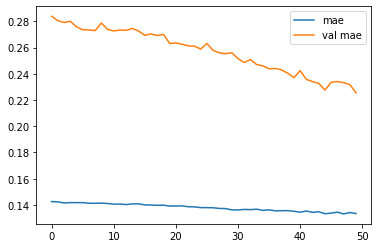

In [60]:
mae2_1 = history2_1.history['mae']
val_mae2_1 = history2_1.history['val_mae']
epoch2_1 = range(len(mae2_1))

plt.plot(epoch2_1, mae2_1, label='mae')
plt.plot(epoch2_1, val_mae2_1, label='val mae')
plt.legend()
plt.show()

In [61]:
prediction2_1 = forecast_predict(model2, test_cabaimerah_, time_size=win_size1, batch_size=5)

data_result2_1 = prediction2_1[(len(x_train))-win_size1:-1, -1 ]
data_result2_1 = scal_range.inverse_transform(data_result2_1.reshape(-1, 1))
data_result2_1 = data_result2_1.reshape(-1)
mae2_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_1)
mape2_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_1)
mse2_1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_1)

rmse2_1 = math.sqrt(mse2_1.numpy())
print(mae2_1.numpy(), mape2_1.numpy(), rmse2_1)

data_new_cabaimerah2_1 = pd.DataFrame()
data_new_cabaimerah2_1['actual'] = x_test
data_new_cabaimerah2_1['prediction'] = data_result2_1
data_new_cabaimerah2_1.to_csv('cabaimerah_model3_sgd_type2.csv')

data_new_cabaimerah2

199/199 [==============================] - 1s 4ms/step
6777.3643 16.186954 8082.880922047534


,actual,prediction
0,40450,37646.207031
1,39500,37623.953125
2,37200,37601.531250
3,36850,37618.148438
4,35850,37662.394531
...,...,...
229,40450,37940.300781
230,53850,37935.539062
231,51150,37920.878906
232,40750,37934.578125


#### Type 3

In [62]:
history2_2 = model2.fit(train_step2, epochs=50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 1s 13ms/step - loss: 0.0391 - mae: 0.1585 - mape: 582579.4375 - val_loss: 0.0685 - val_mae: 0.2202 - val_mape: 48.7934
Epoch 2/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0392 - mae: 0.1601 - mape: 609159.1875 - val_loss: 0.0673 - val_mae: 0.2186 - val_mape: 48.9199
Epoch 3/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0389 - mae: 0.1604 - mape: 626569.5000 - val_loss: 0.0667 - val_mae: 0.2177 - val_mape: 49.0089
Epoch 4/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0389 - mae: 0.1602 - mape: 620803.0000 - val_loss: 0.0664 - val_mae: 0.2174 - val_mape: 49.0442
Epoch 5/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0389 - mae: 0.1601 - mape: 615937.4375 - val_loss: 0.0657 - val_mae: 0.2164 - val_mape: 49.1358
Epoch 6/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0387 - mae: 0.1597 - mape: 617154.6875 - val_loss: 0.0656 - val_mae: 0

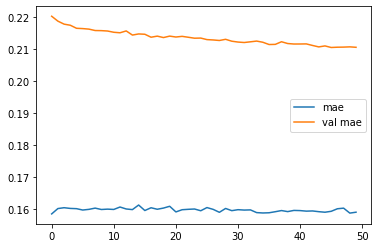

In [63]:
mae2_2 = history2_2.history['mae']
val_mae2_2 = history2_2.history['val_mae']
epoch2_2 = range(len(mae2_2))

plt.plot(epoch2_2, mae2_2, label='mae')
plt.plot(epoch2_2, val_mae2_2, label='val mae')
plt.legend()
plt.show()

In [64]:
prediction2_2 = forecast_predict(model2, test_cabaimerah_, time_size=win_size2, batch_size=5)

data_result2_2 = prediction2_2[(len(x_train))-win_size2:-1, -1 ]
data_result2_2 = scal_range.inverse_transform(data_result2_2.reshape(-1, 1))
data_result2_2 = data_result2_2.reshape(-1)
mae2_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_2)
mape2_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_2)
mse2_2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_2)

rmse2_2 = math.sqrt(mse2_2.numpy())
print(mae2_2.numpy(), mape2_2.numpy(), rmse2_2)

data_new_cabaimerah2_2 = pd.DataFrame()
data_new_cabaimerah2_2['actual'] = x_test
data_new_cabaimerah2_2['prediction'] = data_result2_2
data_new_cabaimerah2_2.to_csv('cabaimerah_model3_sgd-type3.csv')

data_new_cabaimerah2_2

181/181 [==============================] - 1s 4ms/step
6565.409 16.206734 7634.991552058194


,actual,prediction
0,40450,39504.828125
1,39500,39715.417969
2,37200,40049.570312
3,36850,39816.902344
4,35850,39613.210938
...,...,...
229,40450,43695.246094
230,53850,43956.371094
231,51150,43899.148438
232,40750,43743.664062


### Adam

In [65]:
model2_a= Sequential([
    Conv1D(16, kernel_size=2, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(24, return_sequences=True),
    Dropout(0.3),
    LSTM(80),
    Dense(24, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

model2_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model2_a.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 16)          48        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 lstm_10 (LSTM)              (None, None, 24)          3936      
                                                                 
 dropout_1 (Dropout)         (None, None, 24)          0         
                                                                 
 lstm_11 (LSTM)              (None, 80)                33600     
                                                                 
 dense_13 (Dense)            (None, 24)                1944      
                                                      

#### type 1

In [66]:
history2_a = model2_a.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 4s 34ms/step - loss: 0.0625 - mae: 0.2012 - mape: 75.2977 - val_loss: 0.1826 - val_mae: 0.3685 - val_mape: 60.7069
Epoch 2/50
44/44 [==============================] - 1s 17ms/step - loss: 0.0260 - mae: 0.1382 - mape: 85.7030 - val_loss: 0.1064 - val_mae: 0.2773 - val_mape: 50.8668
Epoch 3/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0230 - mae: 0.1332 - mape: 90.6668 - val_loss: 0.0920 - val_mae: 0.2577 - val_mape: 49.7626
Epoch 4/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0229 - mae: 0.1335 - mape: 91.8904 - val_loss: 0.1105 - val_mae: 0.2824 - val_mape: 51.1830
Epoch 5/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0225 - mae: 0.1348 - mape: 95.2268 - val_loss: 0.1062 - val_mae: 0.2770 - val_mape: 50.8634
Epoch 6/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0227 - mae: 0.1342 - mape: 93.0824 - val_loss: 0.1026 - val_mae: 0.2722 - val_mape: 50.567

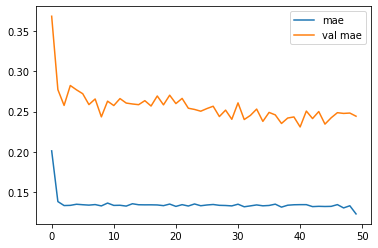

In [67]:
mae2_a = history2_a.history['mae']
val_mae2_a = history2_a.history['val_mae']
epoch2_a = range(len(mae2_a))

plt.plot(epoch2_a, mae2_a, label='mae')
plt.plot(epoch2_a, val_mae2_a, label='val mae')
plt.legend()
plt.show()

In [68]:
prediction2_a = forecast_predict(model2_a, test_cabaimerah_, time_size=win_size, batch_size=5)

data_result2_a = prediction2_a[(len(x_train))-win_size:-1, -1 ]
data_result2_a = scal_range.inverse_transform(data_result2_a.reshape(-1, 1))
data_result2_a = data_result2_a.reshape(-1)
mae2_a = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a)
mape2_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a)
mse2_a = tf.keras.metrics.mean_squared_error(x_test, data_result2_a)

rmse2_a = math.sqrt(mse2_a.numpy())
print(mae2_a.numpy(), mape2_a.numpy(), rmse2_a)

data_new_cabaimerah2_a = pd.DataFrame()
data_new_cabaimerah2_a['actual'] = x_test
data_new_cabaimerah2_a['prediction'] = data_result2_a
data_new_cabaimerah2_a.to_csv('cabaimerah_model3_adam-type1.csv')

data_new_cabaimerah2_a

131/131 [==============================] - 1s 6ms/step
7010.45 16.805645 8320.778809702852


,actual,prediction
0,40450,38939.214844
1,39500,38708.906250
2,37200,39346.492188
3,36850,39147.890625
4,35850,38981.664062
...,...,...
229,40450,41849.519531
230,53850,42042.863281
231,51150,42181.269531
232,40750,42056.414062


#### Type 2

In [69]:
history2_a1 = model2_a.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0291 - mae: 0.1335 - mape: 363642.1875 - val_loss: 0.0731 - val_mae: 0.2266 - val_mape: 48.6652
Epoch 2/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0282 - mae: 0.1324 - mape: 358457.7812 - val_loss: 0.0682 - val_mae: 0.2189 - val_mape: 48.9951
Epoch 3/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0284 - mae: 0.1302 - mape: 265238.3438 - val_loss: 0.0726 - val_mae: 0.2252 - val_mape: 48.7727
Epoch 4/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0269 - mae: 0.1269 - mape: 302300.5312 - val_loss: 0.0793 - val_mae: 0.2358 - val_mape: 48.9708
Epoch 5/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0277 - mae: 0.1288 - mape: 363173.7188 - val_loss: 0.0610 - val_mae: 0.2103 - val_mape: 51.1398
Epoch 6/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0270 - mae: 0.1254 - mape: 274047.8750 - val_loss: 0.0709 - val_

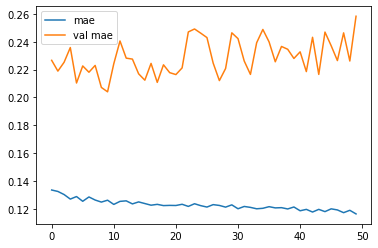

In [70]:
mae2_a1 = history2_a1.history['mae']
val_mae2_a1 = history2_a1.history['val_mae']
epoch2_a1 = range(len(mae2_a1))

plt.plot(epoch2_a1, mae2_a1, label='mae')
plt.plot(epoch2_a1, val_mae2_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 3ms/step
6836.7817 17.601463 8179.913691476213


,actual,prediction
0,40450,42395.582031
1,39500,41291.503906
2,37200,44333.843750
3,36850,43307.902344
4,35850,43118.894531
...,...,...
229,40450,49381.421875
230,53850,49029.511719
231,51150,48820.648438
232,40750,48696.273438


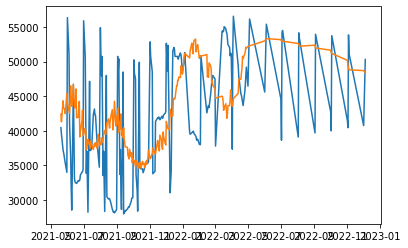

In [71]:
prediction2_a1 = forecast_predict(model2_a, test_cabaimerah_, time_size=win_size1, batch_size=5)

data_result2_a1 = prediction2_a1[(len(x_train))-win_size1:-1, -1 ]
data_result2_a1 = scal_range.inverse_transform(data_result2_a1.reshape(-1, 1))
data_result2_a1 = data_result2_a1.reshape(-1)
mae2_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a1)
mape2_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a1)
mse2_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a1)

rmse2_a1 = math.sqrt(mse2_a1.numpy())
print(mae2_a1.numpy(), mape2_a1.numpy(), rmse2_a1)

data_new_cabaimerah2_a1 = pd.DataFrame()
data_new_cabaimerah2_a1['actual'] = x_test
data_new_cabaimerah2_a1['prediction'] = data_result2_a1
data_new_cabaimerah2_a1.to_csv('cabaimerah_model3_adam-type2.csv')

plt.plot(y_test, data_new_cabaimerah2_a1.actual)
plt.plot(y_test, data_new_cabaimerah2_a1.prediction)
data_new_cabaimerah2_a1

#### Type 3

In [72]:
history2_a2 = model2_a.fit(train_step2, epochs= 50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 1s 13ms/step - loss: 0.0328 - mae: 0.1437 - mape: 525496.5625 - val_loss: 0.0936 - val_mae: 0.2587 - val_mape: 49.8882
Epoch 2/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0321 - mae: 0.1414 - mape: 477206.2500 - val_loss: 0.0882 - val_mae: 0.2512 - val_mape: 49.6079
Epoch 3/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0324 - mae: 0.1421 - mape: 496444.0625 - val_loss: 0.0871 - val_mae: 0.2495 - val_mape: 49.5372
Epoch 4/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0314 - mae: 0.1398 - mape: 505084.0312 - val_loss: 0.0856 - val_mae: 0.2473 - val_mape: 49.4373
Epoch 5/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0318 - mae: 0.1405 - mape: 500199.1875 - val_loss: 0.0842 - val_mae: 0.2451 - val_mape: 49.3280
Epoch 6/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0316 - mae: 0.1397 - mape: 508164.0625 - val_loss: 0.0840 - val_mae: 0

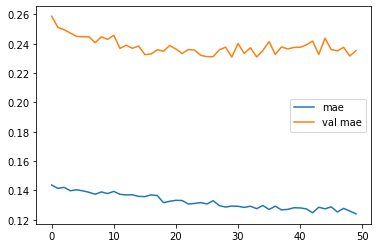

In [73]:
mae2_a2 = history2_a2.history['mae']
val_mae2_a2 = history2_a2.history['val_mae']
epoch2_a2 = range(len(mae2_a2))

plt.plot(epoch2_a2, mae2_a2, label='mae')
plt.plot(epoch2_a2, val_mae2_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 4ms/step
8064.4023 19.607044 9734.250869995081


,actual,prediction
0,40450,43329.957031
1,39500,43355.562500
2,37200,43230.945312
3,36850,42724.054688
4,35850,45902.312500
...,...,...
229,40450,43546.062500
230,53850,44602.289062
231,51150,44622.914062
232,40750,44235.726562


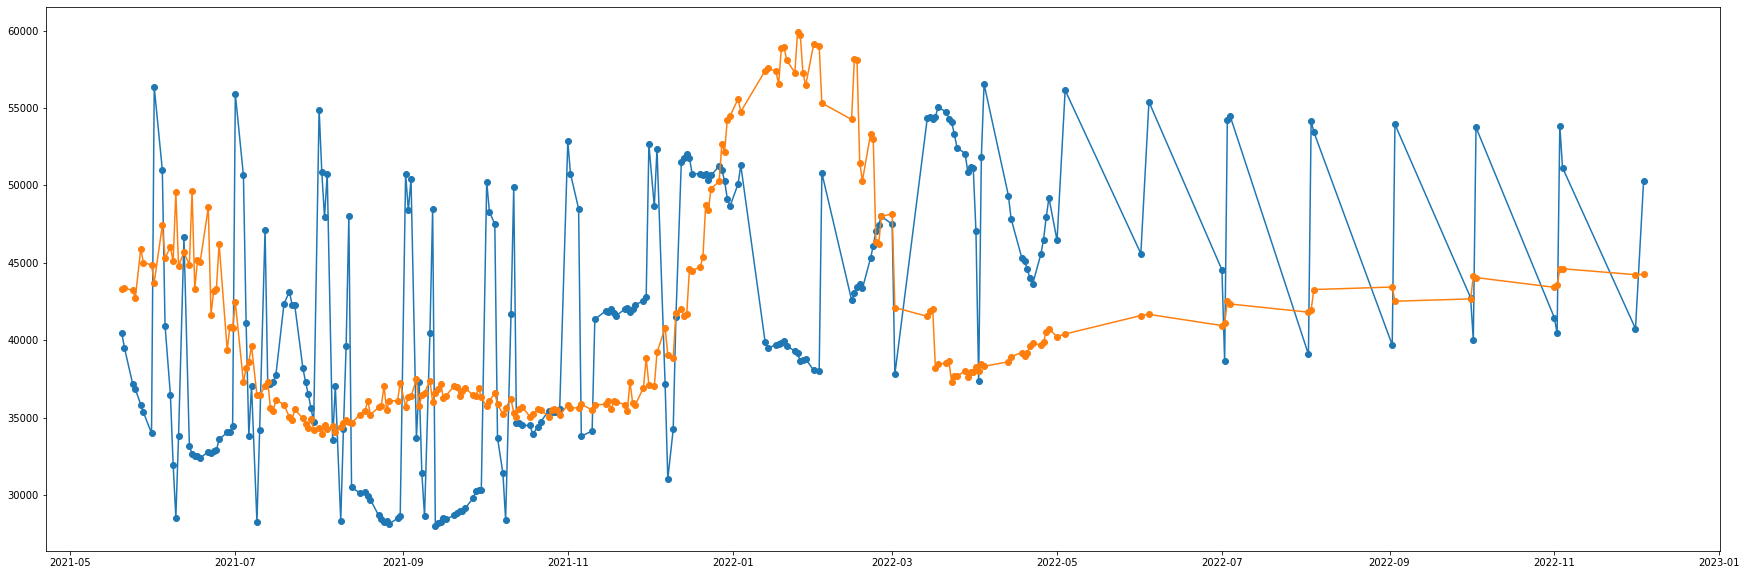

In [74]:
prediction2_a2 = forecast_predict(model2_a, test_cabaimerah_, time_size=win_size2, batch_size=5)

data_result2_a2 = prediction2_a2[(len(x_train))-win_size2:-1, -1 ]
data_result2_a2 = scal_range.inverse_transform(data_result2_a2.reshape(-1, 1))
data_result2_a2 = data_result2_a2.reshape(-1)
mae2_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a2)
mape2_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a2)
mse2_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a2)

rmse2_a2 = math.sqrt(mse2_a2.numpy())
print(mae2_a2.numpy(), mape2_a2.numpy(), rmse2_a2)

data_new_cabaimerah2_a2 = pd.DataFrame()
data_new_cabaimerah2_a2['actual'] = x_test
data_new_cabaimerah2_a2['prediction'] = data_result2_a2
data_new_cabaimerah2_a2.to_csv('cabaimerah_model3_adam_type3.csv')

plt.figure(figsize=(30, 10))
plt.plot(y_test,data_new_cabaimerah2_a2.actual, '-o')
plt.plot(y_test,data_new_cabaimerah2_a2.prediction, '-o')
data_new_cabaimerah2_a2